**ReadMe**

The question 2,3 is answered in part 1

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
%cd /content/drive/My\ Drive/Winter\ 2022/CME241

Mounted at /content/drive
/content/drive/My Drive/Winter 2022/CME241


In [2]:
from rl.markov_process import *
from rl.distribution import *
from rl.markov_decision_process import *
from rl.td import *
from rl.function_approx import *
from typing import Tuple, Sequence, Iterator, List, Dict
from rl.chapter3.simple_inventory_mdp_cap import *
from rl.approximate_dynamic_programming import *
from operator import itemgetter
from rl.policy import *
from rl.monte_carlo import *
import matplotlib.pyplot as plt
import numpy as np
import time
from rl.dynamic_programming import *
from typing import Sequence, Callable, Tuple, Iterator, List
from dataclasses import dataclass

#1. LSPI for American Put Options Pricing

##1.1 Overview

The state is current price (s) and time before expiration (t)

The action is only to exercise or to continue. 

For the action continue, reward will be 0, and the s changes into next s, and t = t-1.

For the action exercise, reward will be g(s), and the state transits into a terminal state.

The terminal state is any state with t=0.

For this problem specfically, let us first create an MDP for this problem. (Note that we cannot do the backward induction, because we cannot suddenly start at the last timestep without passing through all the previous time steps)

In [ ]:
#First, we create a class for the state
# Note that the current state will contain wealth and time
#Let say that wealth is stored directly as float and time is stored directly as int for simplicity

@dataclass(frozen=True)
class WealthTimeState:
    wealth: float
    time: int

#Next, we create the action state. In this case, action will also be float, but we will save it in a class for systematicity

@dataclass(frozen=True)
class AllocationState:
    allocation: float

##1.2 Put Option MDP Solution from chapter 8

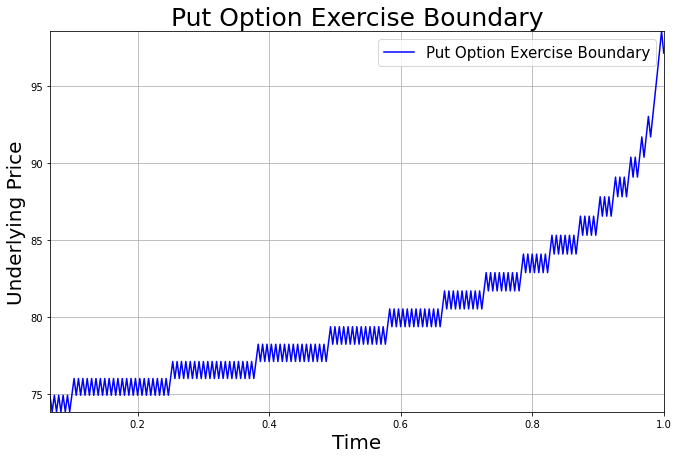

European Price = 7.459
American Price = 7.971


In [3]:
from dataclasses import dataclass
from typing import Callable, Tuple, Iterator, Sequence, List
import numpy as np
from rl.dynamic_programming import V
from scipy.stats import norm
from rl.markov_decision_process import Terminal, NonTerminal
from rl.policy import FiniteDeterministicPolicy
from rl.distribution import Constant, Categorical
from rl.finite_horizon import optimal_vf_and_policy


@dataclass(frozen=True)
class OptimalExerciseBinTree:

    spot_price: float
    payoff: Callable[[float, float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int

    def european_price(self, is_call: bool, strike: float) -> float:
        sigma_sqrt: float = self.vol * np.sqrt(self.expiry)
        d1: float = (np.log(self.spot_price / strike) +
                     (self.rate + self.vol ** 2 / 2.) * self.expiry) \
            / sigma_sqrt
        d2: float = d1 - sigma_sqrt
        if is_call:
            ret = self.spot_price * norm.cdf(d1) - \
                strike * np.exp(-self.rate * self.expiry) * norm.cdf(d2)
        else:
            ret = strike * np.exp(-self.rate * self.expiry) * norm.cdf(-d2) - \
                self.spot_price * norm.cdf(-d1)
        return ret

    def dt(self) -> float:
        return self.expiry / self.num_steps

    def state_price(self, i: int, j: int) -> float:
        return self.spot_price * np.exp((2 * j - i) * self.vol *
                                        np.sqrt(self.dt()))

    def get_opt_vf_and_policy(self) -> \
            Iterator[Tuple[V[int], FiniteDeterministicPolicy[int, bool]]]:
        dt: float = self.dt()
        up_factor: float = np.exp(self.vol * np.sqrt(dt))
        up_prob: float = (np.exp(self.rate * dt) * up_factor - 1) / \
            (up_factor * up_factor - 1)
        return optimal_vf_and_policy(
            steps=[
                {NonTerminal(j): {
                    True: Constant(
                        (
                            Terminal(-1),
                            self.payoff(i * dt, self.state_price(i, j))
                        )
                    ),
                    False: Categorical(
                        {
                            (NonTerminal(j + 1), 0.): up_prob,
                            (NonTerminal(j), 0.): 1 - up_prob
                        }
                    )
                } for j in range(i + 1)}
                for i in range(self.num_steps + 1)
            ],
            gamma=np.exp(-self.rate * dt)
        )

    def option_exercise_boundary(
        self,
        policy_seq: Sequence[FiniteDeterministicPolicy[int, bool]],
        is_call: bool
    ) -> Sequence[Tuple[float, float]]:
        dt: float = self.dt()
        ex_boundary: List[Tuple[float, float]] = []
        for i in range(self.num_steps + 1):
            ex_points = [j for j in range(i + 1)
                         if policy_seq[i].action_for[j] and
                         self.payoff(i * dt, self.state_price(i, j)) > 0]
            if len(ex_points) > 0:
                boundary_pt = min(ex_points) if is_call else max(ex_points)
                ex_boundary.append(
                    (i * dt, opt_ex_bin_tree.state_price(i, boundary_pt))
                )
        return ex_boundary


if __name__ == '__main__':
    from rl.gen_utils.plot_funcs import plot_list_of_curves
    spot_price_val: float = 100.0
    strike: float = 100.0
    is_call: bool = False
    expiry_val: float = 1.0
    rate_val: float = 0.05
    vol_val: float = 0.25
    num_steps_val: int = 300

    if is_call:
        opt_payoff = lambda _, x: max(x - strike, 0)
    else:
        opt_payoff = lambda _, x: max(strike - x, 0)

    opt_ex_bin_tree: OptimalExerciseBinTree = OptimalExerciseBinTree(
        spot_price=spot_price_val,
        payoff=opt_payoff,
        expiry=expiry_val,
        rate=rate_val,
        vol=vol_val,
        num_steps=num_steps_val
    )

    vf_seq, policy_seq = zip(*opt_ex_bin_tree.get_opt_vf_and_policy())
    ex_boundary: Sequence[Tuple[float, float]] = \
        opt_ex_bin_tree.option_exercise_boundary(policy_seq, is_call)
    time_pts, ex_bound_pts = zip(*ex_boundary)
    label = ("Call" if is_call else "Put") + " Option Exercise Boundary"
    plot_list_of_curves(
        list_of_x_vals=[time_pts],
        list_of_y_vals=[ex_bound_pts],
        list_of_colors=["b"],
        list_of_curve_labels=[label],
        x_label="Time",
        y_label="Underlying Price",
        title=label
    )

    european: float = opt_ex_bin_tree.european_price(is_call, strike)
    print(f"European Price = {european:.3f}")

    am_price: float = vf_seq[0][NonTerminal(0)]
    print(f"American Price = {am_price:.3f}")

##1.3 LSPI

###Greedy Action and Function Approximation

Use linear embedding.

$\phi((s,t)) = [s, t]$

Define deterministic policy based on the state (s,t) and the learned parameter $w_s, w_t, w_0$

The return for exercise is $\max(0,strike-s)$

The (approximated) return for continue is $w_0 + w_t t + w_s s$.

Therefore, the optimal action at state $(s,t)$ will be to exercise if and only if
\begin{align*}
  \max(0,strike-s) \ge w_0 + w_t t + w_s s
\end{align*}

In [12]:
strike: float = 100.0

def optimal_value(s: float,
                  t: float,
                  w_0: float,
                  w_s: float,
                  w_t: float,
                  strike: float = 100.0):
  return max([0, strike-s, w_0+w_t*t+w_s*s])

def optimal_action(s: float,
                  t: float,
                  w_0: float,
                  w_s: float,
                  w_t: float,
                  strike: float = 100.0):
  return 'exercise' if max(0, strike-s) >= w_0+w_t*t+w_s*s else 'continue'

The optimal (greedy) policy will be the policy in which we always choose optimal action as specified above.

###Price Dynamics

We use binary tree for this case. For simplicity, we will ignore the interest rate and the risk neutral porabbility. 

We wil go ahead and assume that the price become 1.2 with probability 0.35 and 0.9 with probability 0.65.

For a more precise, we can try to find $p_{up}, p_{down}, s_{up}, s_{down}$ via moment matching.

In [16]:
def next_step_price(s: float, 
                    pup: float = 0.35,
                    sup: float = 1.2,
                    sdown: float = 0.9):
  return s*sup if np.random.uniform() <= pup else s*sdown

###Observation

Since the behavioural policy is to always continue. Therefore, we will observe all prices from t=T to t=1

In [60]:
def observe(start_price:float = 60,
            strike: float = 100,
            T:float = 60):
  
  s_array = []
  t_array = []

  s = start_price

  for t in range(T,0,-1):
    t_array.append(t)
    s_array.append(s)
    s = next_step_price(s)

  return s_array, t_array

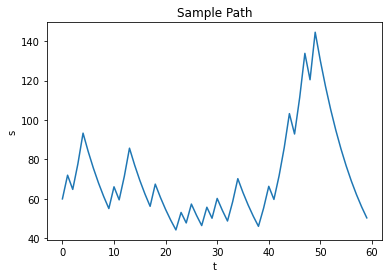

In [61]:
s_array, t_array = observe()
plt.plot(s_array)
plt.title('Sample Path')
plt.ylabel('s')
plt.xlabel('t')
plt.show()

At each, $(s,t)$ we expect 

\begin{align*}
  w_0 + w_t t + w_s s_t = \max(0, strike-s_{t-1}, w_0 + w_t (t-1) + w_s s_{t-1})
\end{align*}

Thus, we create the sequence of $\max(0,  strike-s_{t-1}, w_0 + w_t (t-1) + w_s s_{t-1})$.

In [101]:
s_np = np.flip(np.array(s_array))

#Initialize 
w_0 = 0
w_s = 0
w_t = 0

#Note that s_np is in the way that s_1 is at position 0 and s_T is at position T-1
#Therefore, s_t = s_np[t-1]
expected = [max(0, strike-s_np[t-2], w_0 + w_t*(t-1) +w_s*s_np[t-2]) for t in range(2,T+1)]

We also expect the last position when t = 1 to have the Q-value of continue = 0.

In [102]:
expected = [0] + expected

In [104]:
matrix = np.zeros((T, 3))

matrix[:,0] = 1
matrix[:,1] = s_np
matrix[:,2] = np.arange(1, T+1)

We want to minimize the quadratic loss of the distance between 
\begin{align*}
  matrix [w_0, w_s, w_t]^T - expected^T
\end{align*}

In [107]:
new_w_0, new_w_s, new_w_t = np.linalg.inv(matrix.T @matrix)@matrix.T@expected

This will become a new estimated for $w_0, w_s, w_t$

###Mathematical Notation

We want
\begin{align*}
  w_0 + w_t t + w_s s_t = \max(0, strike-s_{t-1}, w_0 + w_t (t-1) + w_s s_{t-1})
\end{align*}
.

Therefore, we try to minimize
\begin{align*}
  \Vert w_0 + w_t t + w_s s_t 0- \max(0, strike-s_{t-1}, w_0 + w_t (t-1) + w_s s_{t-1}) \Vert_2^2
\end{align*}
.

The first argument is linear in $w$, but the secodn argument is not. Therefore, this problem is hard to solve, although this will be the solution for a dynamics (assume no stochasticity).

Since we want this problem to be tractable, we therefore ignore the fact that the secodn argument will change when we change the value of $w$.

Thus, this will become a quadratic programming without any constraint, amking it solvable via projection method.

Another way to think of the ability to relex the dependency of the second term on the change of $w$ is to think of $w$ as consisting of $w$ of this iteratuion and the $w$ of the previous iteration.

The one from the previous iteration will occur in the second term and the one of the current iteration will be in the first term.

Since we cannot change the $w$ of the previous iteration, our task is then to minimize the loss by only adjusting the value of the current $w$.

###On recursion.

In our example, we use a naive idea of creating a matrix and the vector of interest. Then we find the pseudo inverse of the matrix.

However, since the inverse of a square matrix will cost the tije complexity of $O(n)$. Finding the pseudo-inverse frequently will make the algorithm compuattionally expensive.

In our case, it may be easy given that the size is small, but in some other applications the increment in compuattion cost can be problematic, such as in imaging where increasing resolution will require $O(n^2)$ or $O(n^3)$ depending on whether it is 2-D or 3-D.

In the attached file, there will be some example on how the use of rescursion in projection will make the program more efficient, which is from EE263.

The file is in Julia, so I cannot out it in the python notebook.

###Stacking

Now, we can try to stack everything together.

In [111]:
num_episode= 500

w_0_array, w_s_array, w_t_array = [], [], []

start_point_state_value_array = []

T=60
strike = 100
start = 60

#Initialize
w_0, w_s, w_t = 0, 0, 0

for _ in range(num_episode):
  #Observe
  s_array, t_array = observe()

  #Contruct expected
  s_np = np.flip(np.array(s_array))
  expected = [0]+[max(0, strike-s_np[t-2], w_0 + w_t*(t-1) +w_s*s_np[t-2]) for t in range(2,T+1)]

  #Construct matrix
  matrix = np.zeros((T, 3))
  matrix[:,0] = 1
  matrix[:,1] = s_np
  matrix[:,2] = np.arange(1, T+1)

  #Inverse and update w
  w_0, w_s, w_t = np.linalg.inv(matrix.T @matrix)@matrix.T@expected

  #Store
  w_0_array.append(w_0)
  w_s_array.append(w_s)
  w_t_array.append(w_t)

  start_point_state_value_array.append(T*w_t + start*w_s + w_0)

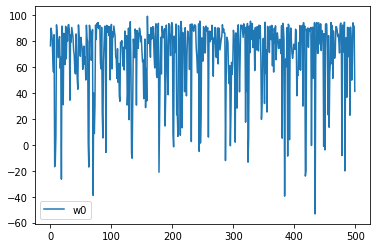

In [120]:
plt.plot(w_0_array, label='w0')
plt.legend()
plt.show()

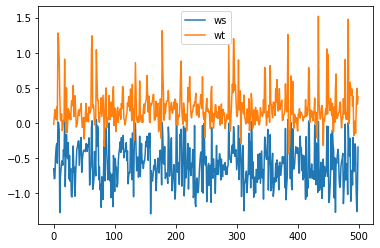

In [119]:
plt.plot(w_s_array, label='ws')
plt.plot(w_t_array, label='wt')
plt.legend()
plt.show()

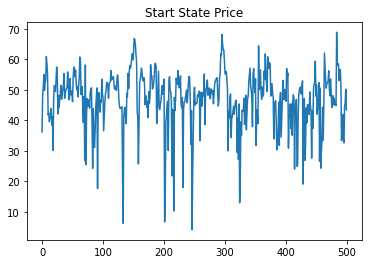

In [122]:
plt.plot(start_point_state_value_array)
plt.title('Start State Price')
plt.title('Start State Price')
plt.show()

Thus, we can find the estimated state value of the start point.

In [123]:
print('Start Point State Value:', T*w_t + start*w_s + w_0)

Start Point State Value: 43.4063007396131


According to the graph, this is quite unreliable.